In [1]:
from keras.datasets.fashion_mnist import load_data
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

#https://keras.io/api/datasets/fashion_mnist/

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


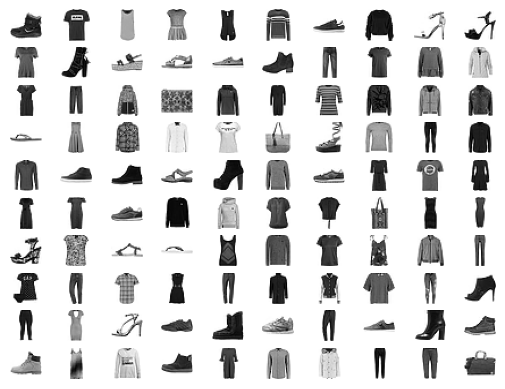

In [2]:
from matplotlib import pyplot
for i in range(100):
 # define subplot
 pyplot.subplot(10, 10, 1 + i)
 # turn off axis
 pyplot.axis('off')
 # plot raw pixel data
 pyplot.imshow(trainX[i], cmap='gray_r')
pyplot.show()

In [3]:
# example of training an unconditional gan on the fashion mnist dataset
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout

def define_discriminator(in_shape=(28,28,1)):
 model = Sequential()
 # downsample
 model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
 model.add(LeakyReLU(alpha=0.2))
 # downsample
 model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
 model.add(LeakyReLU(alpha=0.2))
 # classifier
 model.add(Flatten())
 model.add(Dropout(0.4))
 model.add(Dense(1, activation='sigmoid'))
 # compile model
 opt = Adam(learning_rate=0.0002, beta_1=0.5)
 model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
 return model

 # define the standalone generator model
def define_generator(latent_dim):
 model = Sequential()
 # foundation for 7x7 image
 n_nodes = 128 * 7 * 7
 model.add(Dense(n_nodes, input_dim=latent_dim))
 model.add(LeakyReLU(alpha=0.2))
 model.add(Reshape((7, 7, 128)))
 # upsample to 14x14
 model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
 model.add(LeakyReLU(alpha=0.2))
 # upsample to 28x28
 model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
 model.add(LeakyReLU(alpha=0.2))
 # generate
 model.add(Conv2D(1, (7,7), activation='tanh', padding='same'))
 return model

def define_gan(generator, discriminator):
# make weights in the discriminator not trainable
  discriminator.trainable = False
 # connect them
  model = Sequential()
 # add generator
  model.add(generator)
 # add the discriminator
  model.add(discriminator)
 # compile model
  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [4]:
# load fashion mnist images
def load_real_samples():
 # load dataset
 (trainX, _), (_, _) = load_data()
 # expand to 3d, e.g. add channels
 X = expand_dims(trainX, axis=-1)
 # convert from ints to floats
 X = X.astype('float32')
 # scale from [0,255] to [-1,1]
 X = (X - 127.5) / 127.5
 return X

# select real samples
def generate_real_samples(dataset, n_samples):
 # choose random instances
 ix = randint(0, dataset.shape[0], n_samples)
 # select images
 X = dataset[ix]
 # generate class labels
 y = ones((n_samples, 1))
 return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
 # generate points in the latent space
 x_input = randn(latent_dim * n_samples)
 # reshape into a batch of inputs for the network
 x_input = x_input.reshape(n_samples, latent_dim)
 return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
 # generate points in latent space
 x_input = generate_latent_points(latent_dim, n_samples)
 # predict outputs
 X = generator.predict(x_input, verbose=0)
 # create class labels
 y = zeros((n_samples, 1))
 return X, y

In [7]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=3, n_batch=128):
 bat_per_epo = int(dataset.shape[0] / n_batch)
 half_batch = int(n_batch / 2)
 # manually enumerate epochs
 for i in range(n_epochs):
 # enumerate batches over the training set
    for j in range(bat_per_epo):
 # get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
 # update discriminator model weights
        d_loss1, _ = d_model.train_on_batch(X_real, y_real)
 # generate 'fake' examples
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
 # update discriminator model weights
        d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
 # prepare points in latent space as input for the generator
        X_gan = generate_latent_points(latent_dim, n_batch)
 # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
 # update the generator via the discriminator's error
        g_loss = gan_model.train_on_batch(X_gan, y_gan)
 # summarize loss on this batch
        print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
        (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
 # save the generator model
 g_model.save('generator.keras')

In [8]:
    # size of the latent space
    latent_dim = 100
    # create the discriminator
    discriminator = define_discriminator()
    # create the generator
    generator = define_generator(latent_dim)
    # create the gan
    gan_model = define_gan(generator, discriminator)
    # load image data
    dataset = load_real_samples()
    # train model
    train(generator, discriminator, gan_model, dataset, latent_dim)

>1, 1/468, d1=0.628, d2=0.661 g=0.691
>1, 2/468, d1=0.649, d2=0.662 g=0.689
>1, 3/468, d1=0.656, d2=0.664 g=0.687
>1, 4/468, d1=0.658, d2=0.665 g=0.685
>1, 5/468, d1=0.659, d2=0.665 g=0.682
>1, 6/468, d1=0.661, d2=0.666 g=0.679
>1, 7/468, d1=0.662, d2=0.667 g=0.675
>1, 8/468, d1=0.664, d2=0.669 g=0.671
>1, 9/468, d1=0.666, d2=0.672 g=0.667
>1, 10/468, d1=0.670, d2=0.675 g=0.662
>1, 11/468, d1=0.672, d2=0.678 g=0.657
>1, 12/468, d1=0.675, d2=0.680 g=0.652
>1, 13/468, d1=0.678, d2=0.683 g=0.648
>1, 14/468, d1=0.681, d2=0.686 g=0.643
>1, 15/468, d1=0.683, d2=0.688 g=0.639
>1, 16/468, d1=0.686, d2=0.690 g=0.634
>1, 17/468, d1=0.688, d2=0.693 g=0.631
>1, 18/468, d1=0.690, d2=0.694 g=0.627
>1, 19/468, d1=0.692, d2=0.696 g=0.623
>1, 20/468, d1=0.694, d2=0.698 g=0.620
>1, 21/468, d1=0.697, d2=0.700 g=0.617
>1, 22/468, d1=0.699, d2=0.702 g=0.614
>1, 23/468, d1=0.701, d2=0.704 g=0.611
>1, 24/468, d1=0.702, d2=0.705 g=0.609
>1, 25/468, d1=0.704, d2=0.707 g=0.607
>1, 26/468, d1=0.705, d2=0.708 g=0

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/stepWARNING:tensorflow:5 out of the last 2816 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000015A2AF628E0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


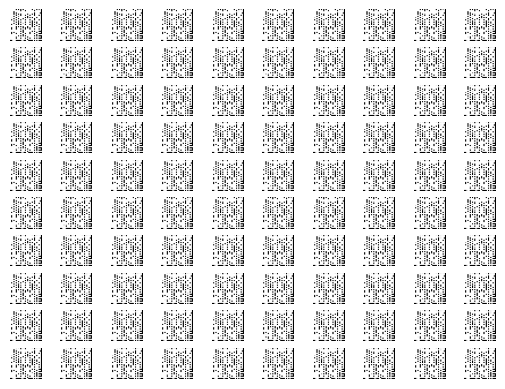

In [11]:
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
 # generate points in the latent space
 x_input = randn(latent_dim * n_samples)
 # reshape into a batch of inputs for the network
 x_input = x_input.reshape(n_samples, latent_dim)
 return x_input

# create and save a plot of generated images (reversed grayscale)
def show_plot(examples, n):
 # plot images
 for i in range(n * n):
 # define subplot
    pyplot.subplot(n, n, 1 + i)
 # turn off axis
    pyplot.axis('off')
 # plot raw pixel data
    pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
pyplot.show()

# load model
model = load_model('generator.keras')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# plot the result
show_plot(X, 10)